# Mechanistic Interpretability: Modular Addition

This notebook walks through the core mech interp techniques on a 1-layer transformer
trained on modular addition (the Nanda grokking setup).

**Sections:**
1. Load a trained model & dataset
2. Inspect attention patterns
3. Cache & visualize activations (residual stream norms)
4. Ablation study — which heads matter?
5. Fourier analysis of embeddings
6. Linear probing — does the residual stream encode the answer?

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from project.data import (
    build_shared_vocab,
    FullModularAdditionDataset,
    ModularAdditionConfig,
    causal_lm_collate,
)
from project.lit_causal_lm import LitCausalLM
from project.interp import (
    get_cache,
    list_hook_names,
    head_ablation_sweep,
    train_probe,
)
from project.interp.viz import (
    plot_attention_pattern,
    plot_attention_heads,
    plot_activation_norms,
    plot_ablation_results,
)

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

/Users/quentinauster/dev/training_template/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load model & data

Point `CKPT_PATH` at a checkpoint from a training run.
If you don't have one yet, run:
```bash
./scripts/smoke_local.sh
```
and grab the path from `outputs/<date>/<time>/checkpoints/last.ckpt`.

In [5]:
# --- CONFIG (edit these) ---
CKPT_PATH = "../../outputs/2026-02-07/14-41-13/checkpoints/last.ckpt"  # <-- update this
MODULUS = 113
DEVICE = "mps"  # or "cuda" / "cpu"
# ---------------------------

# Load model from checkpoint
lit_model = LitCausalLM.load_from_checkpoint(CKPT_PATH, map_location=DEVICE)
lit_model.eval()
model = lit_model.model  # the TinyTransformer (HookedRootModule)

print(f"Model: {model.n_layers} layers, {model.n_heads} heads, d_model={model.d_model}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: 1 layers, 4 heads, d_model=128
Parameters: 230,784


In [19]:
# Build vocab and dataset
vocab = build_shared_vocab(MODULUS)
cfg = ModularAdditionConfig(modulus=MODULUS, answer_only_supervision=True)

val_ds = FullModularAdditionDataset(
    vocab=vocab, cfg=cfg, frac_train=0.3, split="val", seed=0,
)
print(f"Val set size: {len(val_ds)} pairs")

# Grab a small batch for interp
N = 256
batch_items = [val_ds[i] for i in range(N)]
batch = causal_lm_collate(batch_items, pad_id=vocab.pad_id)
input_ids = batch["input_ids"].to(DEVICE)
target_ids = batch["target_ids"].to(DEVICE)

# Show a few examples
for i in range(5):
    toks = vocab.decode(input_ids[i].tolist())
    print(" ".join(toks))

Val set size: 8939 pairs
<BOS> 50 + 67 = 4 <EOS>
<BOS> 92 + 107 = 86 <EOS>
<BOS> 29 + 14 = 43 <EOS>
<BOS> 76 + 53 = 16 <EOS>
<BOS> 78 + 80 = 45 <EOS>


## 2. Attention patterns

Visualize what tokens each head attends to. In modular addition, we expect
heads that attend to the operand positions (the digits before `+` and `=`).

In [20]:
# Run a single example and cache attention patterns
example_ids = input_ids[:1]  # single example
logits, cache = get_cache(
    model, example_ids,
    names_filter=lambda n: "attn_pattern" in n,
)

# Get token labels for axes
tokens = vocab.decode(example_ids[0].tolist())
print(f"Input: {' '.join(tokens)}")
print(f"Available hooks: {list_hook_names(model, lambda n: 'attn_pattern' in n)}")

Input: <BOS> 50 + 67 = 4 <EOS>
Available hooks: ['blocks.0.attn.hook_attn_pattern']


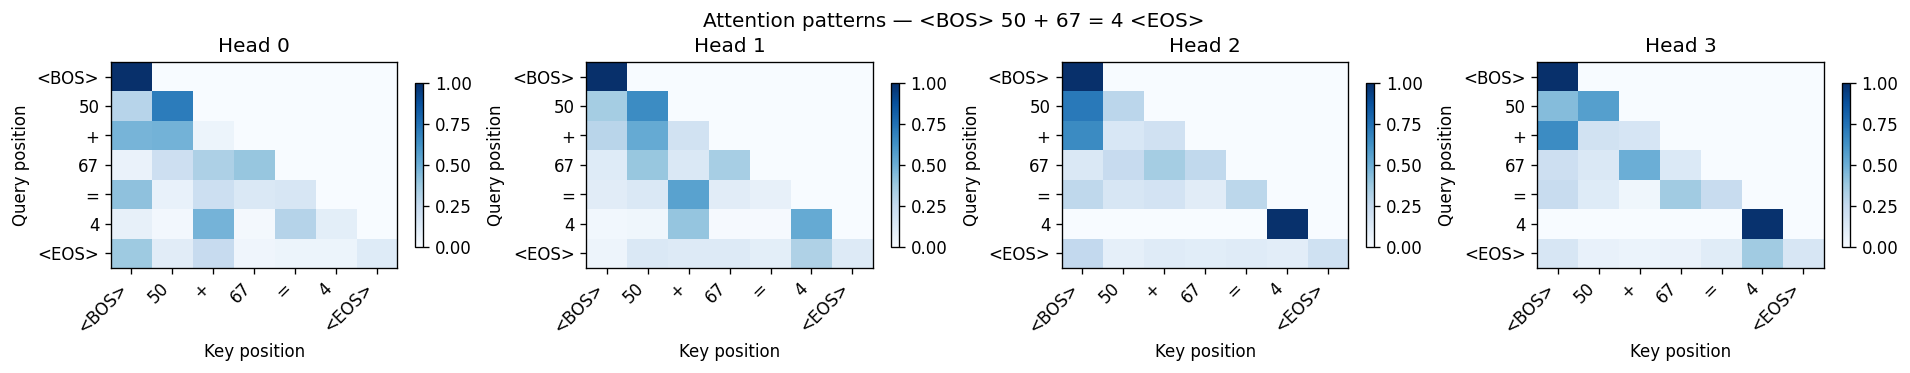

In [21]:
# Plot all heads in layer 0
attn = cache["blocks.0.attn.hook_attn_pattern"]  # (1, n_heads, T, T)
attn_np = attn[0].detach().cpu().float().numpy()  # (n_heads, T, T)

fig = plot_attention_heads(attn_np, tokens=tokens)
fig.suptitle(f"Attention patterns — {' '.join(tokens)}", y=1.02)
plt.show()

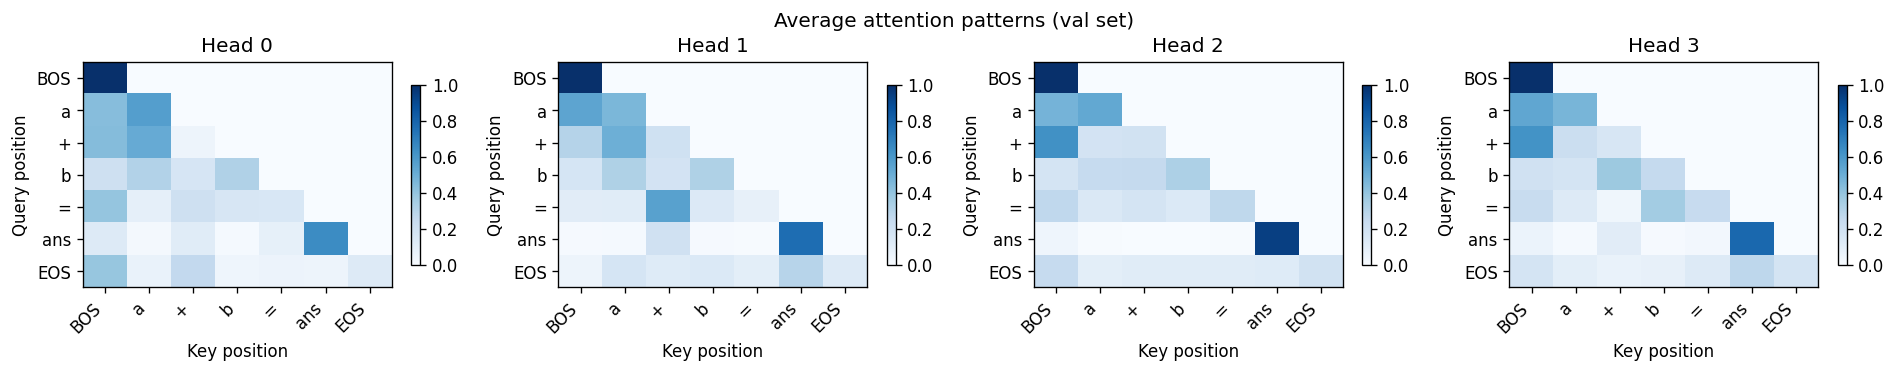

In [22]:
# Average attention patterns across the val batch
logits_batch, cache_batch = get_cache(
    model, input_ids,
    names_filter=lambda n: "attn_pattern" in n,
)

avg_attn = cache_batch["blocks.0.attn.hook_attn_pattern"].mean(dim=0)  # (n_heads, T, T)
avg_attn_np = avg_attn.detach().cpu().float().numpy()

# Use positional labels since tokens vary across batch
pos_labels = ["BOS", "a", "+", "b", "=", "ans", "EOS"]
fig = plot_attention_heads(avg_attn_np, tokens=pos_labels)
fig.suptitle("Average attention patterns (val set)", y=1.02)
plt.show()

## 3. Residual stream activations

Look at how the residual stream norms evolve across positions.
In a model that has learned modular addition, we expect the representation
at the `=` position to carry the most information.

In [9]:
# Cache residual stream activations
_, cache_resid = get_cache(
    model, input_ids,
    names_filter=lambda n: "resid" in n,
)

print("Residual stream hooks:")
for name in sorted(cache_resid.keys()):
    shape = cache_resid[name].shape
    print(f"  {name}: {shape}")

Residual stream hooks:
  blocks.0.hook_resid_mid: torch.Size([256, 7, 128])
  blocks.0.hook_resid_post: torch.Size([256, 7, 128])
  blocks.0.hook_resid_pre: torch.Size([256, 7, 128])
  hook_resid_final: torch.Size([256, 7, 128])


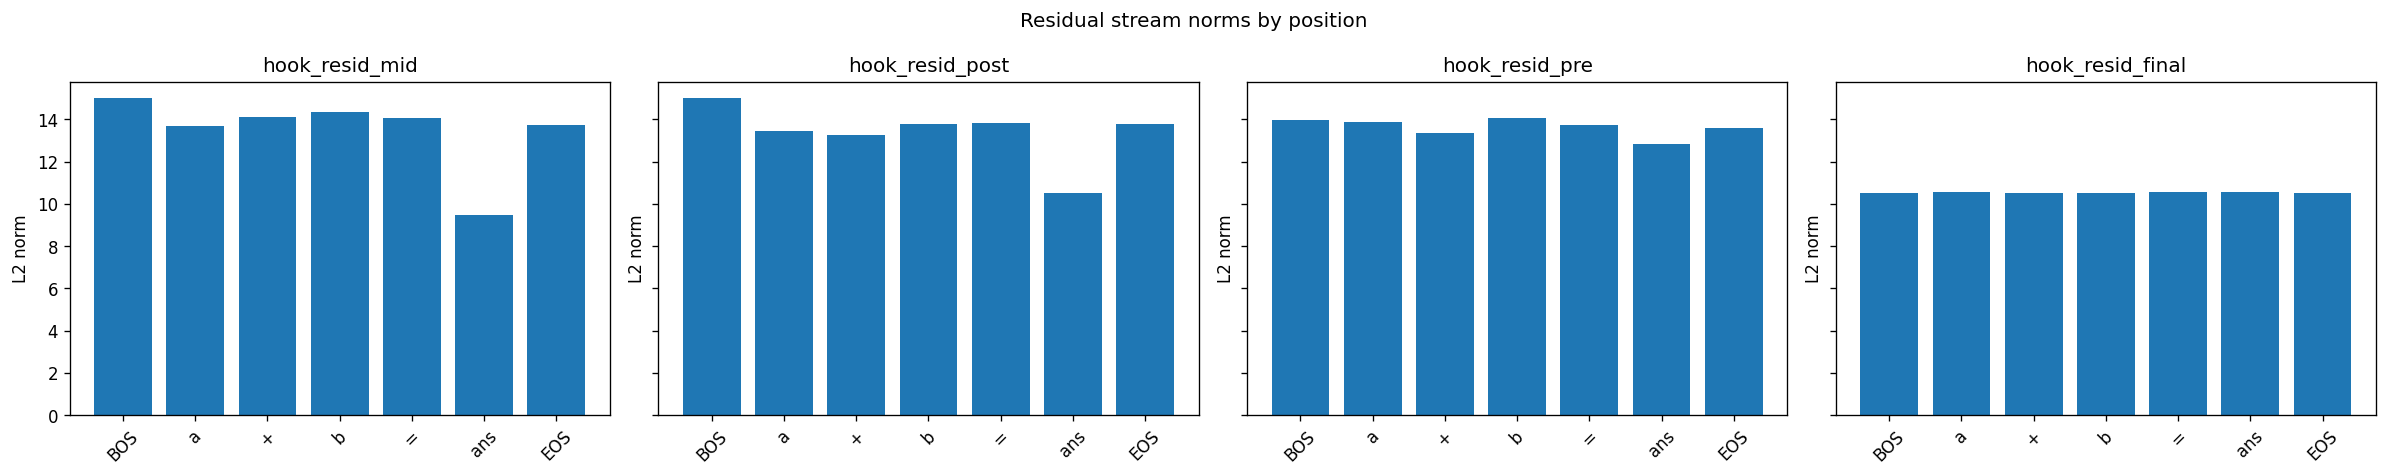

In [10]:
# Plot residual stream norms at each position, averaged over the batch
fig, axes = plt.subplots(1, len(cache_resid), figsize=(5 * len(cache_resid), 4), sharey=True)
if not hasattr(axes, "__len__"):
    axes = [axes]

pos_labels = ["BOS", "a", "+", "b", "=", "ans", "EOS"]

for ax, (name, act) in zip(axes, sorted(cache_resid.items())):
    # act shape: (B, T, d_model)
    norms = act.float().norm(dim=-1).mean(dim=0).detach().cpu().numpy()  # (T,)
    ax.bar(range(len(norms)), norms)
    ax.set_xticks(range(len(pos_labels)))
    ax.set_xticklabels(pos_labels, rotation=45)
    ax.set_title(name.split(".")[-1])
    ax.set_ylabel("L2 norm")

fig.suptitle("Residual stream norms by position")
plt.tight_layout()
plt.show()

## 4. Ablation study

Which attention heads are important for getting the right answer?
We zero-ablate each head and measure the change in loss at the answer position.

In [11]:
# Define a metric: cross-entropy loss at the answer position
import torch.nn.functional as F

def answer_loss(logits: torch.Tensor) -> float:
    """CE loss at the supervised (answer) position, averaged over batch."""
    mask = target_ids != -100
    loss = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        target_ids.view(-1),
        ignore_index=-100,
    )
    return loss.item()

# Run ablation sweep over all heads
results = head_ablation_sweep(
    model, input_ids, answer_loss, ablation_type="zero",
)

for r in results:
    print(f"{r.component:40s}  baseline={r.baseline_metric:.4f}  ablated={r.ablated_metric:.4f}  delta={r.delta:+.4f}")

blocks.0.attn.hook_z:head_2               baseline=0.0407  ablated=0.0590  delta=+0.0183
blocks.0.attn.hook_z:head_1               baseline=0.0407  ablated=0.0556  delta=+0.0149
blocks.0.attn.hook_z:head_3               baseline=0.0407  ablated=0.0538  delta=+0.0131
blocks.0.attn.hook_z:head_0               baseline=0.0407  ablated=0.0497  delta=+0.0090


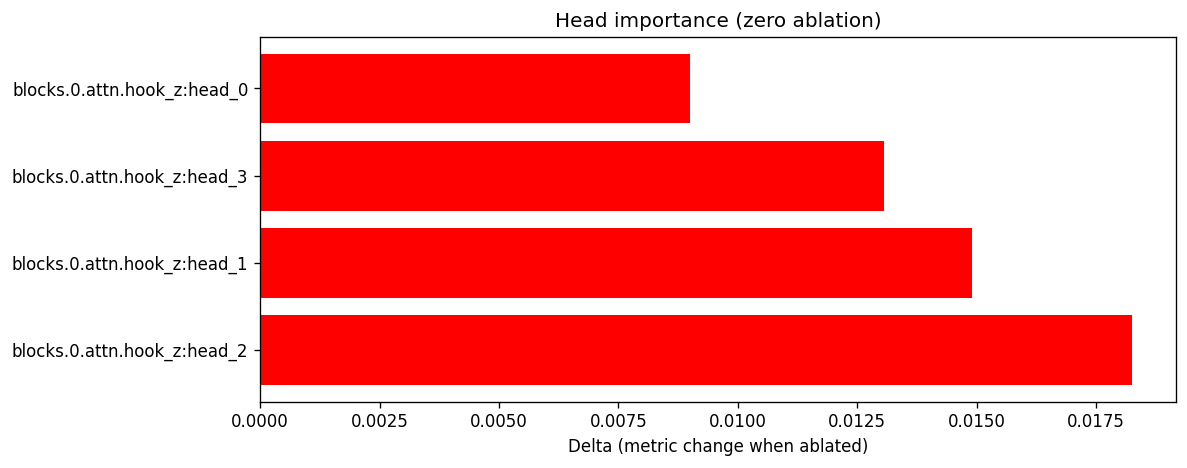

In [12]:
ax = plot_ablation_results(results, title="Head importance (zero ablation)")
plt.show()

## 5. Fourier analysis of embeddings

A key finding from Nanda et al.: the model represents numbers using
Fourier components of the modular group. We check whether the digit
embeddings have structure in the DFT domain.

Digit embeddings shape: (113, 128)


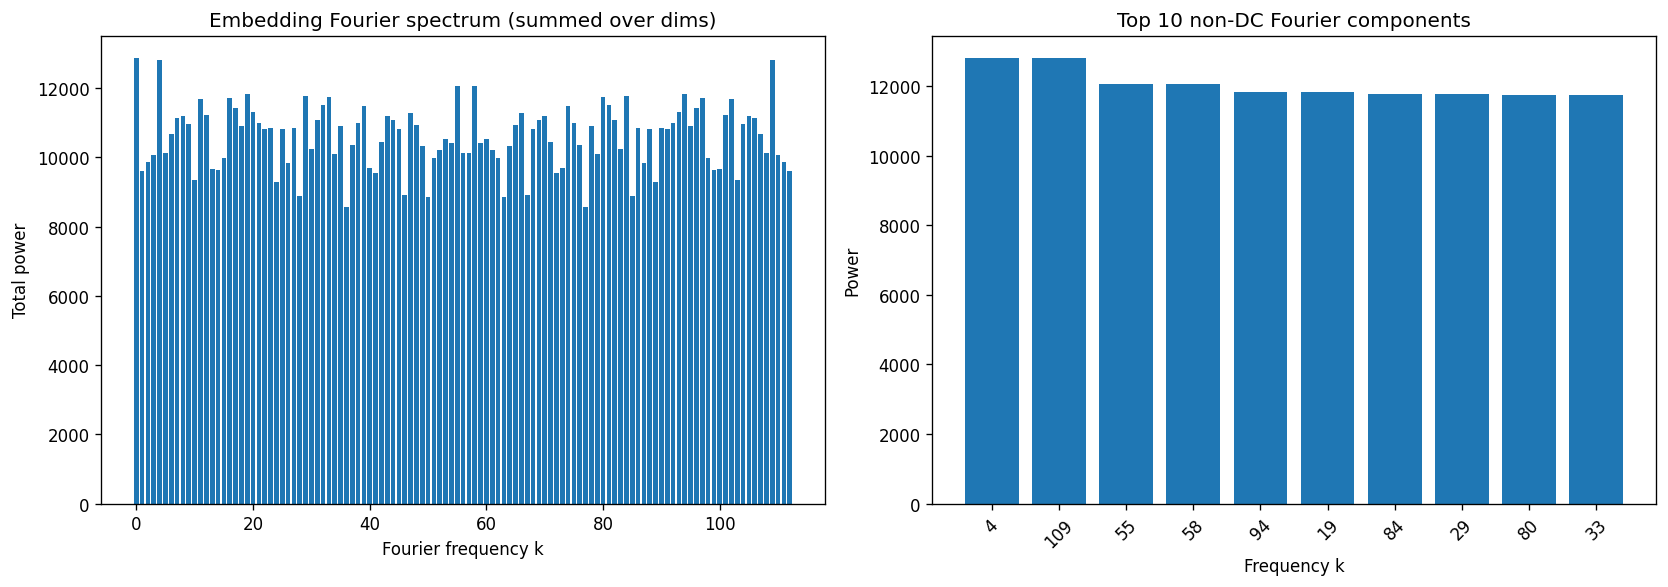


Top frequencies: [4, 109, 55, 58, 94, 19, 84, 29, 80, 33]
DC power fraction: 1.07%


In [13]:
# Extract digit embeddings (token ids for "0" through "p-1")
digit_ids = [vocab.token_to_id[str(i)] for i in range(MODULUS)]
digit_embeds = model.embed_tokens.weight[digit_ids].detach().cpu().float().numpy()  # (p, d_model)

print(f"Digit embeddings shape: {digit_embeds.shape}")

# Compute DFT along the digit axis for each embedding dimension
# Each column of digit_embeds is a function f: Z_p -> R
# Its DFT reveals which Fourier frequencies the model uses.
dft = np.fft.fft(digit_embeds, axis=0)  # (p, d_model)
dft_power = np.abs(dft) ** 2  # power spectrum

# Sum power across embedding dimensions for each frequency
freq_power = dft_power.sum(axis=1)  # (p,)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot total power per frequency
freqs = np.arange(MODULUS)
ax1.bar(freqs, freq_power)
ax1.set_xlabel("Fourier frequency k")
ax1.set_ylabel("Total power")
ax1.set_title("Embedding Fourier spectrum (summed over dims)")

# Highlight the top frequencies
# Skip DC component (k=0)
top_k = 10
# Use only non-DC frequencies, handle conjugate symmetry
half = MODULUS // 2
non_dc_power = freq_power.copy()
non_dc_power[0] = 0
top_freqs = np.argsort(non_dc_power)[-top_k:][::-1]

ax2.bar(range(top_k), non_dc_power[top_freqs])
ax2.set_xticks(range(top_k))
ax2.set_xticklabels([str(f) for f in top_freqs], rotation=45)
ax2.set_xlabel("Frequency k")
ax2.set_ylabel("Power")
ax2.set_title(f"Top {top_k} non-DC Fourier components")

plt.tight_layout()
plt.show()

print(f"\nTop frequencies: {top_freqs.tolist()}")
print(f"DC power fraction: {freq_power[0] / freq_power.sum():.2%}")

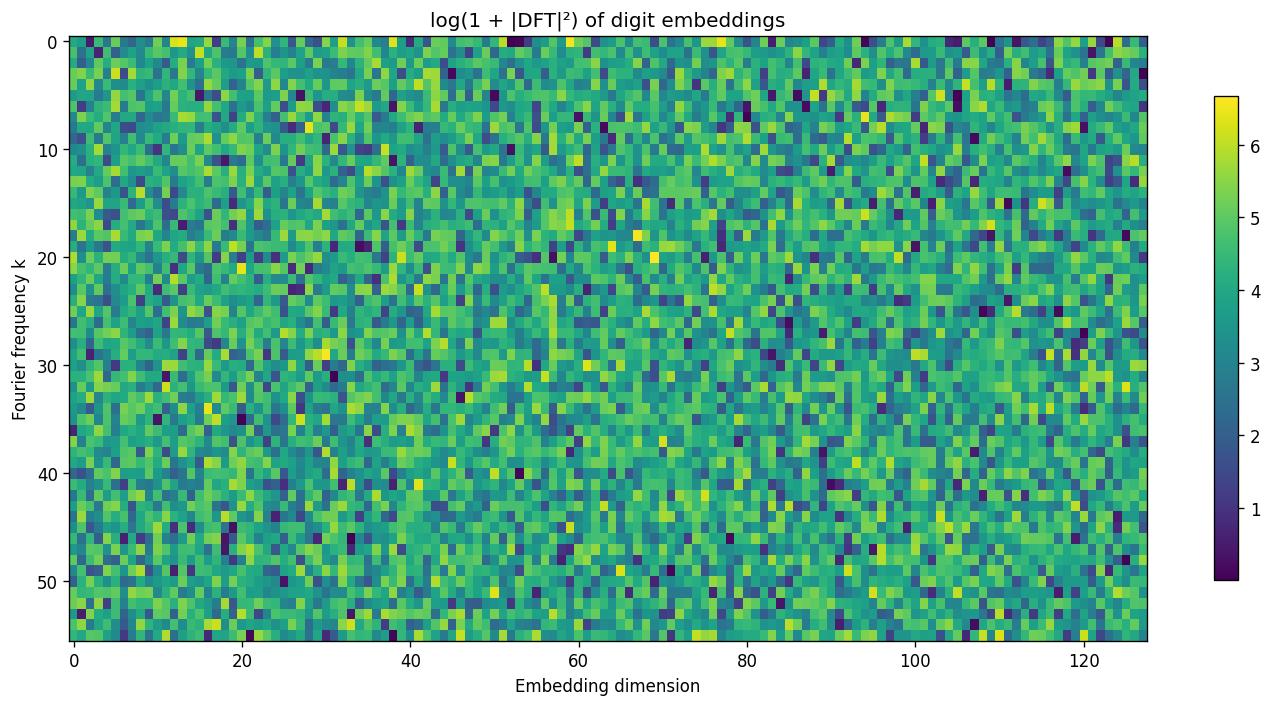

In [14]:
# Visualize the full DFT power heatmap (frequency x embedding dim)
fig, ax = plt.subplots(figsize=(12, 6))
im = ax.imshow(
    np.log1p(dft_power[:half, :]),
    aspect="auto", cmap="viridis",
)
ax.set_xlabel("Embedding dimension")
ax.set_ylabel("Fourier frequency k")
ax.set_title("log(1 + |DFT|²) of digit embeddings")
fig.colorbar(im, ax=ax, shrink=0.8)
plt.tight_layout()
plt.show()

## 6. Linear probing

Can we decode the answer `(a + b) mod p` from the residual stream
at various positions? This tells us *where* in the sequence the model
has computed the answer.

In [15]:
# Cache the final residual stream for the full batch
_, cache_probe = get_cache(
    model, input_ids,
    names_filter=["blocks.0.hook_resid_post"],
)

resid = cache_probe["blocks.0.hook_resid_post"]  # (B, T, d_model)

# Extract answer labels from the dataset
# For each example, answer = (a + b) % p. We can read it from target_ids.
# The supervised position has the answer token id.
answer_mask = target_ids != -100  # (B, T)
answer_token_ids = target_ids.clone()
answer_token_ids[~answer_mask] = 0
answer_labels = answer_token_ids.sum(dim=1)  # each row has exactly one non-(-100) value

# Convert token ids to digit values: token_id - offset
digit_offset = vocab.token_to_id["0"]
answer_digits = (answer_labels - digit_offset).long()

print(f"Residual shape: {resid.shape}")
print(f"Answer digits (first 10): {answer_digits[:10].tolist()}")
print(f"Unique classes: {answer_digits.unique().numel()}")

Residual shape: torch.Size([256, 7, 128])
Answer digits (first 10): [4, 86, 43, 16, 45, 22, 98, 98, 55, 78]
Unique classes: 100


In [16]:
# Probe at each token position
pos_labels = ["BOS", "a", "+", "b", "=", "ans", "EOS"]
T = resid.shape[1]

# Split into probe train/val
split = N // 2
probe_results = {}

for pos in range(T):
    acts = resid[:, pos, :]  # (B, d_model)
    result = train_probe(
        activations=acts[:split],
        labels=answer_digits[:split],
        val_activations=acts[split:],
        val_labels=answer_digits[split:],
        probe_type="classification",
        epochs=200,
        lr=1e-2,
    )
    label = pos_labels[pos] if pos < len(pos_labels) else str(pos)
    probe_results[label] = result
    print(f"  pos={label:4s}  train_acc={result.train_accuracy:.3f}  val_acc={result.val_accuracy:.3f}")

  pos=BOS   train_acc=0.031  val_acc=0.008
  pos=a     train_acc=0.602  val_acc=0.000
  pos=+     train_acc=0.602  val_acc=0.000
  pos=b     train_acc=1.000  val_acc=0.000
  pos==     train_acc=0.781  val_acc=0.008
  pos=ans   train_acc=1.000  val_acc=0.680
  pos=EOS   train_acc=0.992  val_acc=0.523


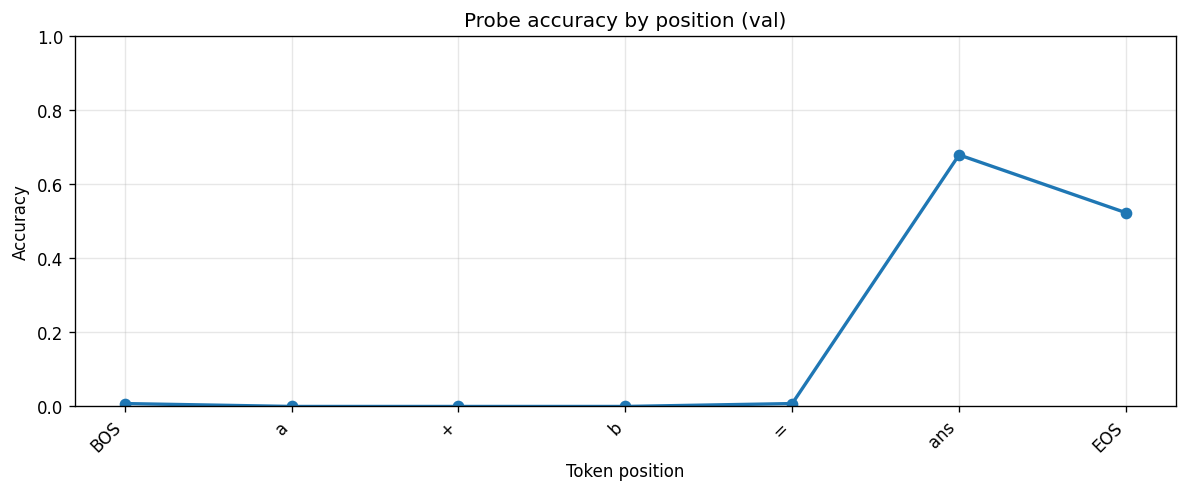

In [17]:
# Plot probe accuracy by position
from project.interp.viz import plot_probe_accuracy_by_layer

layer_accs = {name: r.val_accuracy for name, r in probe_results.items()}
ax = plot_probe_accuracy_by_layer(layer_accs, title="Probe accuracy by position (val)")
ax.set_xlabel("Token position")
plt.show()

## Next steps

- **Train longer** to observe grokking: `trainer.max_epochs=2000` and watch val_acc jump
- **Activation patching**: use `activation_patching()` to trace which positions causally matter
- **Logit lens**: project residual stream states through the unembedding to see intermediate "predictions"
- **Compare checkpoints**: load early (memorized) vs late (generalized) checkpoints and compare Fourier structure